In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

We first have to start defining the model itself. Let's start by writing down our function.

We jus saw in class that M-E assumption, where line profile is constant with depth looks like: 
$$I_\lambda = S_0 + \frac{S_1}{1+\eta \phi_\lambda(\lambda_0,\sigma,a)} $$

Where $S_0$ and $S_1$ determine the depth dependence of the source function, $\eta$ is line-to-continuum opacity ratio, $\lambda_0$ is line center position, $\sigma$ Doppler width and $a$ is the damping.

In [2]:
# Let's start with the profile, which is the most tricky part of the game:
# This piece of code show how to calculate the Voigt profile, which is an essential 
# part of the M-E inversion.

from scipy.special import wofz

# This is the original formulation of Voigt function, by using wofz
def V(x, alpha, gamma):
    
    #Return the Voigt line shape at x with Lorentzian component HWHM gamma
    #and Gaussian component HWHM alpha.

    sigma = alpha / np.sqrt(2 * np.log(2))

    return np.real(wofz((x + 1j*gamma)/sigma/np.sqrt(2))) / sigma /np.sqrt(2*np.pi)



# This is a formulation where we "normalize" the wavelengths in order to get a dimensionless
# wavelength. It should work either way...

# center = lambda_0
# doppler = doppler widht
# damp = damping, in units of doppler broadening
# ll = wavelength array

def voigt(center,doppler,damp,ll):
    
    # we often call this reduced wavelength:
    doppler *= 1.17 # to convert to halfwidht half maximum
    xx = (ll - center)/doppler
    return V(xx,1.0,damp)

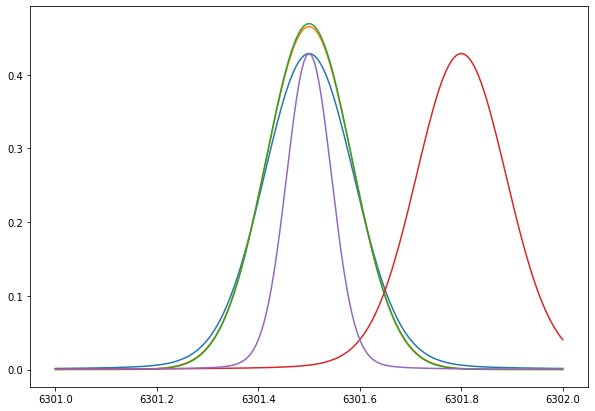

In [6]:
# Test our line absorption profile:

ll = np.linspace(6301.0,6302.,201)

plt.figure(figsize=[10,7])
plt.plot(ll,voigt(6301.5,0.1,0.1,ll))
plt.plot(ll,voigt(6301.5,0.1,0.01,ll))
plt.plot(ll,voigt(6301.5,0.1,0.001,ll))
plt.plot(ll,voigt(6301.8,0.1,0.1,ll))
plt.plot(ll,voigt(6301.5,0.05,0.1,ll))

In [7]:
# Now let's define our model. Model takes the parameters p, that are going to change from 
# example to example, and wavleengths ll, that are going to stay the same. 

# These are hard-coded for 6301 line

def me_scalar(p,ll):
    
    # we have 6 parameters:
    S0 ,S1, eta, shift, width, damping = p
    
    # Note that we have here replaced the line center position with "shift", se below:
    center = 6301.49 * (1.+shift/2.997E5)
    
    # Also, let's assume width was also provided in km/s. Here we transform it to wavle 
    width *= 6301.49/2.997E5
        
    profile = voigt(center,width,damping,ll)
    
    return S0 + S1/(1.+profile*eta)

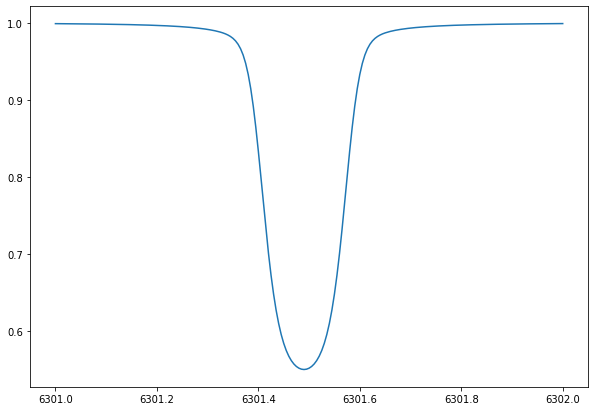

In [8]:
# Let's see if it works
S0 = 0.5 # in units of intensity
S1 = 0.5 # in units of intensity
eta = 20.0 # dimensionless 
shift = 0.0 # in km/s
width = 2.0 # in km/s 
damping = 0.05 # dimension less 
ll = np.linspace(6301.,6302.,201)

spec = me_scalar([S0,S1,eta,shift,width,damping],ll)

plt.figure(figsize=[10,7])
plt.plot(ll,spec)


Looks good! Now time to experiment with some parameters. Let's first consider something that we all feel should be important line strength.

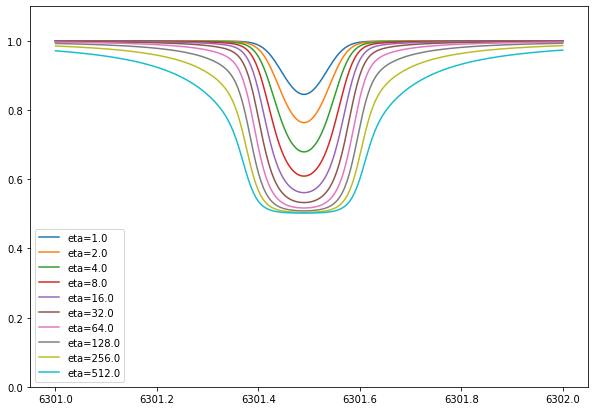

In [13]:
etavar = 1.0

plt.figure(figsize=[10,7])

for i in range(0,10):brew install eigen
    spec = me_scalar([S0,S1,etavar,shift,width,damping],ll)
    plt.plot(ll,spec,label='eta='+str(etavar))
    etavar *= 2.0
plt.ylim([0.0,1.1])

plt.legend()

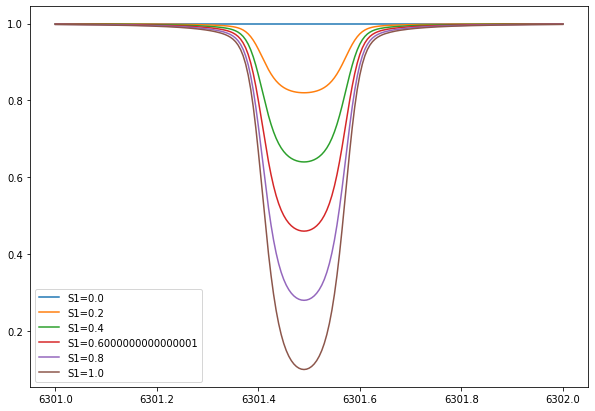

In [14]:
#Now the slope of the source function
S1var = 0.0

plt.figure(figsize=[10,7])

for i in range(0,6):
    spec = me_scalar([1.0-S1var,S1var,eta,shift,width,damping],ll)
    plt.plot(ll,spec,label='S1='+str(S1var))
    S1var += 0.2

plt.legend()

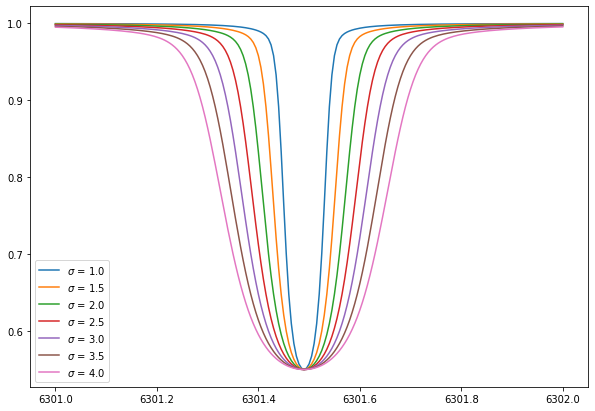

In [15]:
# And now the width
widthvar = 1.0 # in km/s

plt.figure(figsize=[10,7])

for i in range(0,7):
    spec = me_scalar([S0,S1,eta,shift,widthvar,damping],ll)
    plt.plot(ll,spec,label='$\sigma$ = '+str(widthvar))
    widthvar += 0.5

plt.legend()

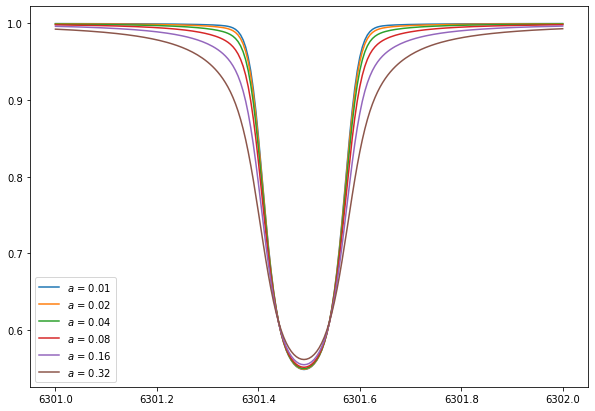

In [19]:
# And now the width
dampvar = 0.01

plt.figure(figsize=[10,7])

for i in range(0,6):
    spec = me_scalar([S0,S1,eta,shift,width,dampvar],ll)
    plt.plot(ll,spec,label='$a$ = '+str(dampvar))
    dampvar *= 2.0

plt.legend()

In [20]:
# Now let's move to the data:

# Let's first look at the data.
from astropy.io import fits


temp = fits.open("/home/milic/data/Hinode_network/hinode_network_c.fits")
temp.info()

Filename: /home/milic/data/Hinode_network/hinode_network_c.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (112, 4, 873, 512)   float64   


In [22]:
stokes = temp[0].data
stokes.shape

(512, 873, 4, 112)

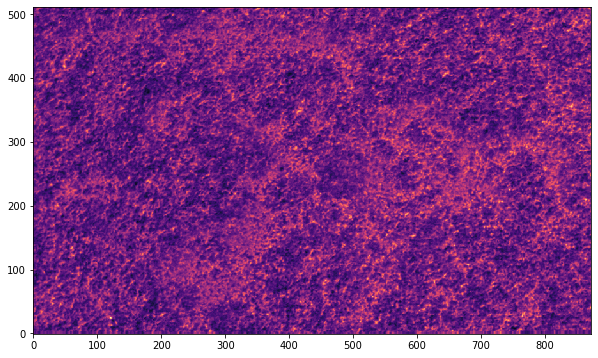

In [24]:
plt.figure(figsize=[10,7])
plt.imshow(stokes[:,:,0,28],origin='lower',cmap='magma')

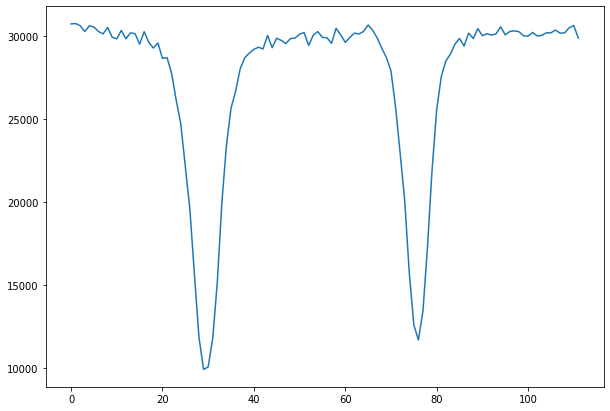

In [25]:
plt.figure(figsize=[10,7])
plt.plot(stokes[133,144,0,:])

In [26]:
stokes /= np.mean(stokes[:,:,0,-10:])

In [28]:
# Let's also assign wavelengths:
ll = np.linspace(0,111,112)
ll = 6302.08 + (ll-56.5)*0.0215

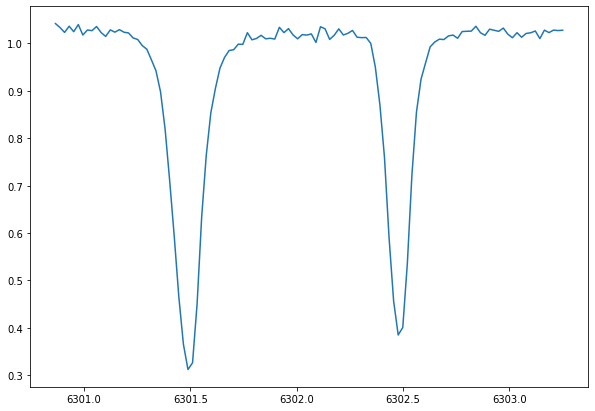

In [29]:
# Plot one spectrum:
plt.figure(figsize=[10,7])
plt.plot(ll,stokes[100,100,0,:])

In [31]:
#let's try now scipy.optimize.minimize

def chi2(params, x, y, error):
    
    #x is ll
    #y are the observed stokes 
    #uncertanties in y
    
    y_model = me_scalar(params,x)
    
    chi2 = np.sum(((y_model - y) / error)**2)
    
    return chi2

In [32]:
# Break the below code in a few steps:
from scipy.optimize import minimize

x_data = ll[:50]
y_data = stokes[100,100,0,:50]
errors = 1E-3 # 'scale' of the uncertainties, in units of intensity

starting_params=[0.6,0.4,70.0,0.0,2.0,0.05]

result = minimize(chi2,starting_params,args=(x_data,y_data,errors))

print (result.x)

[-2.43390457  3.46954736  0.99506657 -0.13326131  2.25084177  0.71812008]


160.2004320192799
1.0426160597651541


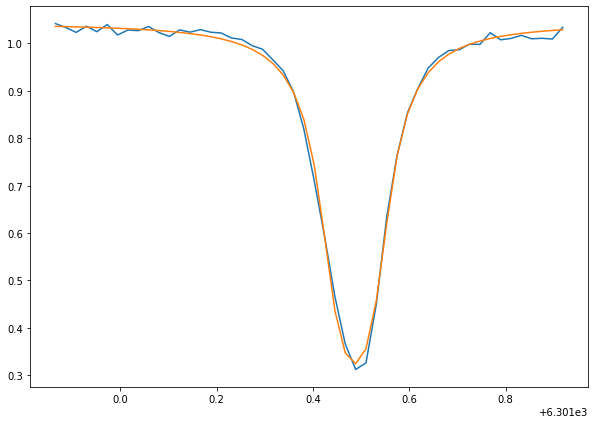

In [39]:
# Reduced chi-squared:
print (chi2(result.x,x_data,y_data,errors)/(50.-6.))

plt.figure(figsize=[10,7])
plt.plot(x_data,y_data)
plt.plot(x_data,me_scalar(result.x,x_data))
print (result.x[0]+ result.x[1]) # This is the continuum level predicted by the code. It is veyr well constrained


[ 0.11953051  0.91364284 17.10179103 -0.27394364  1.33383856  0.66686355]
62.28882296846337
1.0331733509217234


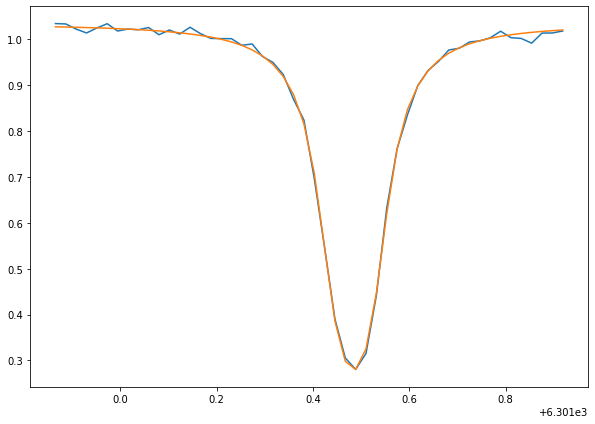

In [44]:
# Now the same but with the bounds:

from scipy.optimize import minimize
x_data = ll[0:50]
y_data = stokes[185,312,0,0:50]
errors = 1E-3

starting_params=[0.3,0.7,1.0,0.0,2.0,0.05]

result = minimize(chi2,starting_params,args=(x_data,y_data,errors),bounds=[(0.1,0.4),(0.0,1.0),(1.,100.),(-20,20),(0.5,5.0),(0,1)])
print (result.x)
print (chi2(result.x,x_data,y_data,errors)/(50.-6.))
plt.figure(figsize=[10,7])
plt.plot(x_data,y_data)
plt.plot(x_data,me_scalar(result.x,x_data))
print (result.x[0]+ result.x[1])

    

[ 0.17370875  0.86736347 25.43938249 -0.27394812  1.19683673  0.65645088]
68.01546245510745
1.0410722129813055


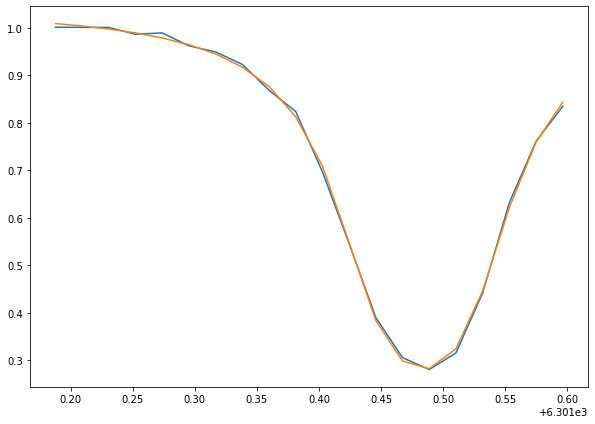

In [46]:
# You can also try restricting to the line core:

from scipy.optimize import minimize
x_data = ll[15:35]
y_data = stokes[185,312,0,15:35]
errors = 1E-3

starting_params=[0.3,0.7,1.0,0.0,2.0,0.05]

result = minimize(chi2,starting_params,args=(x_data,y_data,errors),bounds=[(0.1,0.4),(0.0,1.0),(1.,100.),(-20,20),(0.5,5.0),(0,1)])
print (result.x)
print (chi2(result.x,x_data,y_data,errors)/(20.-6.))
plt.figure(figsize=[10,7])
plt.plot(x_data,y_data)
plt.plot(x_data,me_scalar(result.x,x_data))
print (result.x[0]+ result.x[1])
